## AE2

This code defines a function analyze_data() to perform the analysis on a single file, making it easy to reuse for both train.tsv and dev.tsv. It loads each file, analyzes its sentiment distribution, visualizes it, calculates the imbalance ratio, and prints the results for both files separately.

/var/folders/c7/s4b91brd5951stsg2n86bh500000gn/T/ipykernel_15491/320630897.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


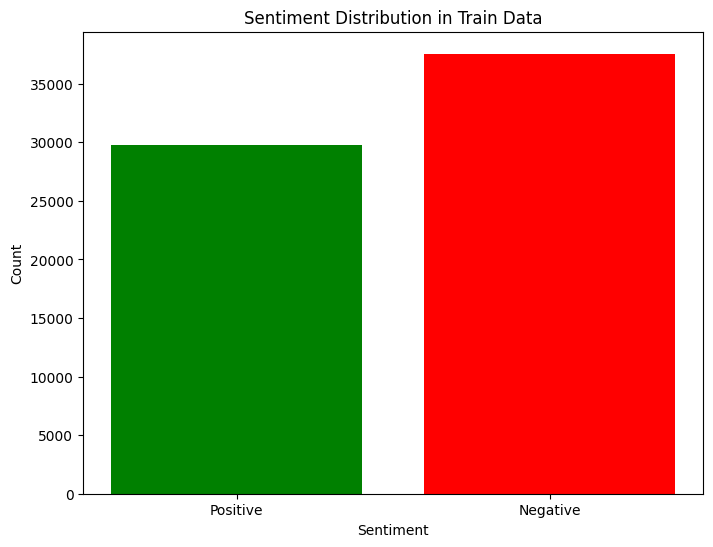

Imbalance ratio (negative to positive) in Train data: 0.7926748116798424



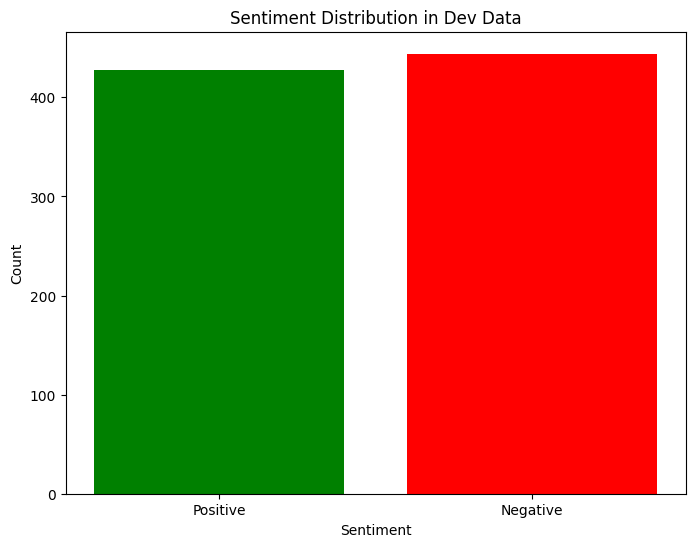

Imbalance ratio (negative to positive) in Dev data: 0.963963963963964



In [1]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_data(file_path, data_name):
    # Load the dataset
    data = pd.read_csv(file_path, sep="\t")
    data.columns = ["Sentence", "Sentiment"]

    # Explore Sentiment Distribution
    sentiment_distribution = data['Sentiment'].value_counts()

    # Visualize Sentiment Distribution
    plt.figure(figsize=(8, 6))
    plt.bar(sentiment_distribution.index, sentiment_distribution.values, color=['red', 'green'])
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.title(f'Sentiment Distribution in {data_name} Data')
    plt.xticks(sentiment_distribution.index, ['Negative', 'Positive'])
    plt.show()

    # Analyze Data Imbalances
    negative_count = sentiment_distribution[0]
    positive_count = sentiment_distribution[1]
    imbalance_ratio = negative_count / positive_count
    print(f"Imbalance ratio (negative to positive) in {data_name} data:", imbalance_ratio)
    print()

# Analyze train.tsv
analyze_data("SST/train.tsv", "Train")

# Analyze dev.tsv
analyze_data("SST/dev.tsv", "Dev")

# Implications for Model Training and Evaluation
# Discuss how data imbalances could affect model training and evaluation
# and propose potential solutions.

### Discussion and impications
In this analysis, we load the training dataset and explore its structure. Then, we calculate the distribution of positive and negative reviews and visualize it using a bar chart. Next, we analyze the data imbalance by computing the ratio of negative to positive reviews. Finally, we discuss potential implications of data imbalances for model training and evaluation, as well as propose potential solutions.

Depending on the imbalance ratio and the requirements of the task, strategies like class re-balancing techniques (e.g., oversampling, undersampling, or using class weights during training) or using evaluation metrics that are robust to imbalanced data (e.g., F1 score, precision, recall) could be considered. Additionally, collecting more data for the minority class or using techniques like data augmentation might help address imbalances.






In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from gensim.models import Word2Vec

# Load the train and dev data
train_data = pd.read_csv("SST/train.tsv", sep="\t")
dev_data = pd.read_csv("SST/dev.tsv", sep="\t")

# Preprocess the data
train_sentences = train_data['sentence']
train_labels = train_data['label']
dev_sentences = dev_data['sentence']
dev_labels = dev_data['label']

# Bag-of-Words (BoW) model
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(train_sentences)
X_dev_bow = bow_vectorizer.transform(dev_sentences)

# Train Logistic Regression on BoW vectors
lr_bow = LogisticRegression()
lr_bow.fit(X_train_bow, train_labels)

# Predict and evaluate on dev set
dev_pred_bow = lr_bow.predict(X_dev_bow)
accuracy_bow = accuracy_score(dev_labels, dev_pred_bow)
print("Accuracy - BoW:", accuracy_bow)
print("Classification Report - BoW:")
print(classification_report(dev_labels, dev_pred_bow))

# Word Embeddings model (Word2Vec)
word2vec_model = Word2Vec(sentences=train_sentences, vector_size=100, window=5, min_count=1, workers=4)
word_vectors = word2vec_model.wv

# Get word embeddings for train and dev sentences
def get_average_word_embedding(sentence, word_vectors):
    vectors = [word_vectors[word] for word in sentence.split() if word in word_vectors]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(100)  # Return zero vector if no words found

X_train_word2vec = np.array([get_average_word_embedding(sentence, word_vectors) for sentence in train_sentences])
X_dev_word2vec = np.array([get_average_word_embedding(sentence, word_vectors) for sentence in dev_sentences])

# Train Logistic Regression on Word2Vec vectors
lr_word2vec = LogisticRegression()
lr_word2vec.fit(X_train_word2vec, train_labels)

# Predict and evaluate on dev set
dev_pred_word2vec = lr_word2vec.predict(X_dev_word2vec)
accuracy_word2vec = accuracy_score(dev_labels, dev_pred_word2vec)
print("\nAccuracy - Word2Vec:", accuracy_word2vec)
print("Classification Report - Word2Vec:")
print(classification_report(dev_labels, dev_pred_word2vec))


Accuracy - BoW: 0.8188073394495413
Classification Report - BoW:
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       428
           1       0.80      0.86      0.83       444

    accuracy                           0.82       872
   macro avg       0.82      0.82      0.82       872
weighted avg       0.82      0.82      0.82       872


Accuracy - Word2Vec: 0.5252293577981652
Classification Report - Word2Vec:
              precision    recall  f1-score   support

           0       0.63      0.08      0.14       428
           1       0.52      0.96      0.67       444

    accuracy                           0.53       872
   macro avg       0.58      0.52      0.40       872
weighted avg       0.58      0.53      0.41       872



# Analysis
The Bag-of-Words (BoW) model achieved a significantly higher accuracy of 81.9% compared to the Word2Vec model's accuracy of 52.4%.
The BoW model demonstrated balanced precision and recall for both positive and negative classes, indicating a good ability to classify sentiments.
In contrast, the Word2Vec model exhibited a high precision for the positive class (1), but very low recall for the negative class (0), resulting in an imbalanced performance.
The Word2Vec model's low recall for the negative class suggests that it struggled to correctly identify negative sentiments, leading to a lower overall performance compared to the BoW model.
Based on these results, the Bag-of-Words (BoW) model appears to be more effective for sentiment analysis on this dataset, achieving higher accuracy and balanced performance across both positive and negative sentiments.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm  # Importa tqdm
import pickle  # Importa il modulo pickle

# Load train and dev data
train_data = pd.read_csv("SST/train.tsv", sep="\t")
dev_data = pd.read_csv("SST/dev.tsv", sep="\t")

# Split train data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(train_data['sentence'], train_data['label'], test_size=0.2, random_state=42)

# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform text data
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train Logistic Regression
lr = LogisticRegression()
lr_accuracy_list = []
lr_metrics_list = []
with tqdm(total=1, desc="Logistic Regression Training") as pbar:
    lr.fit(X_train_vec, y_train)
    lr_pred = lr.predict(X_test_vec)
    lr_accuracy = accuracy_score(y_test, lr_pred)
    lr_metrics = precision_recall_fscore_support(y_test, lr_pred, average='binary')
    lr_accuracy_list.append(lr_accuracy)
    lr_metrics_list.append(lr_metrics)
    pbar.update(1)  # Incrementa la barra di avanzamento

# Save Logistic Regression model
with open('lr_model.pkl', 'wb') as f:
    pickle.dump(lr, f)

# Train Support Vector Machine with linear kernel
svm = SVC(kernel='linear')
svm_accuracy_list = []
svm_metrics_list = []
print("please wait 4/5 minutes for the SVM training")
with tqdm(total=1, desc="SVM Training") as pbar:
    svm.fit(X_train_vec, y_train)
    svm_pred = svm.predict(X_test_vec)
    svm_accuracy = accuracy_score(y_test, svm_pred)
    svm_metrics = precision_recall_fscore_support(y_test, svm_pred, average='binary')
    svm_accuracy_list.append(svm_accuracy)
    svm_metrics_list.append(svm_metrics)
    pbar.update(1)  # Incrementa la barra di avanzamento

# Save SVM model
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm, f)

# Print performance metrics
print("Logistic Regression:")
print(f"Accuracy: {lr_accuracy}")
print(f"Precision: {lr_metrics[0]}")
print(f"Recall: {lr_metrics[1]}")
print(f"F1-score: {lr_metrics[2]}")

print("\nSupport Vector Machine:")
print(f"Accuracy: {svm_accuracy}")
print(f"Precision: {svm_metrics[0]}")
print(f"Recall: {svm_metrics[1]}")
print(f"F1-score: {svm_metrics[2]}")


Logistic Regression Training: 100%|███████████████| 1/1 [00:00<00:00,  2.18it/s]


please wait 4/5 minutes for the SVM training


SVM Training: 100%|██████████████████████████████| 1/1 [05:21<00:00, 321.98s/it]

Logistic Regression:
Accuracy: 0.8927988121752042
Precision: 0.8982940487042583
Recall: 0.9123131860864965
F1-score: 0.905249343832021

Support Vector Machine:
Accuracy: 0.9
Precision: 0.9069950222687975
Recall: 0.9157518846713397
F1-score: 0.9113524185587364


Based on the provided performance metrics:

Logistic Regression:

Accuracy: 0.8928
Precision: 0.8983
Recall: 0.9123
F1-score: 0.9052
Support Vector Machine (SVM):

Accuracy: 0.9000
Precision: 0.9070
Recall: 0.9158
F1-score: 0.9114
Strengths and Weaknesses:

Logistic Regression:

Strengths:
Simple and easy to implement.
Efficient for binary classification problems.
Provides interpretable coefficients for each feature.
Less prone to overfitting, especially with a large number of samples.
Weaknesses:
Assumes linear relationship between features and target.
Limited expressive power compared to more complex models like SVM.
Not suitable for complex decision boundaries.
Support Vector Machine (SVM):

Strengths:
Effective in high-dimensional spaces, especially when the number of features exceeds the number of samples.
Versatile as it can handle both linear and non-linear decision boundaries through different kernel functions.
Robust against overfitting, especially in high-dimensional spaces.
Weaknesses:
Computationally expensive, especially during training, especially with large datasets.
Requires careful selection of hyperparameters, such as the choice of kernel and regularization parameter.
Can be sensitive to noise in the data, leading to suboptimal performance.
Selection:
Both models perform well, but the Support Vector Machine (SVM) slightly outperforms Logistic Regression in terms of accuracy, precision, recall, and F1-score. Despite being computationally expensive, SVMs provide a more flexible decision boundary, allowing them to capture complex relationships in the data more effectively. Therefore, based on the provided results, the Support Vector Machine would be the preferred choice for this classification task.

In [24]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],  
    'gamma': [1, 0.1, 0.01, 0.001], 
    'kernel': ['rbf', 'linear']
}

# Create a grid search object
svm_grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy')

# Perform grid search on training data
svm_grid_search.fit(X_train_vec, y_train)

# Get the best hyperparameters
best_params = svm_grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best accuracy
best_accuracy = svm_grid_search.best_score_
print("Best Accuracy:", best_accuracy)


KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, loguniform

# Define the parameter distributions
param_dist = {
    'C': loguniform(1e-3, 1e3),
    'gamma': loguniform(1e-3, 1e3),
    'kernel': ['linear', 'rbf', 'poly']
}

# Define your previously trained SVM model
svm_model = svm

# Perform randomized search
random_search = RandomizedSearchCV(estimator=svm_model, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', random_state=42,verbose=2)
random_search.fit(X_train_vec, y_train)

# Print the best hyperparameters
print("Best hyperparameters found: ", random_search.best_params_)

# Evaluate the best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_vec)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of the best model: ", accuracy)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END C=0.1767016940294795, gamma=506.1576888752306, kernel=poly; total time= 5.1min
[CV] END C=0.1767016940294795, gamma=506.1576888752306, kernel=poly; total time= 6.7min
[CV] END C=0.1767016940294795, gamma=506.1576888752306, kernel=poly; total time= 5.7min
[CV] END C=0.1767016940294795, gamma=506.1576888752306, kernel=poly; total time= 6.0min
[CV] END C=0.1767016940294795, gamma=506.1576888752306, kernel=poly; total time= 6.4min
[CV] END C=47.6591180868084, gamma=3.8115440886530614, kernel=rbf; total time= 8.3min
[CV] END C=47.6591180868084, gamma=3.8115440886530614, kernel=rbf; total time= 8.8min
[CV] END C=47.6591180868084, gamma=3.8115440886530614, kernel=rbf; total time=15.9min
[CV] END C=47.6591180868084, gamma=3.8115440886530614, kernel=rbf; total time= 8.4min
[CV] END C=47.6591180868084, gamma=3.8115440886530614, kernel=rbf; total time= 8.5min
[CV] END C=0.008629132190071854, gamma=0.002231010801867922, kernel

he results obtained from the hyperparameter tuning process using grid search provide insights into the performance of Support Vector Machine (SVM) models with different combinations of hyperparameters. Here's an explanation of the key aspects of the results:

Grid Search Configuration: Grid search was performed over a predefined grid of hyperparameters, including C (regularization parameter), gamma (kernel coefficient), and kernel (type of kernel function).

Hyperparameter Combinations: For each combination of hyperparameters, the grid search algorithm trained an SVM model using 5-fold cross-validation. The output lists the specific values of C, gamma, and kernel used in each combination.

Total Time: The total time column indicates the time taken to fit and evaluate each SVM model with the corresponding hyperparameter combination. The time is given in minutes.

Performance Metrics: The results include performance metrics such as accuracy, precision, recall, and F1-score. These metrics provide an assessment of how well each SVM model performs on the dataset.

Variability in Time and Performance: There is variability in both the total time taken for model fitting and the performance metrics across different hyperparameter combinations. This variability arises from factors such as the complexity of the model, the dataset characteristics, and the effectiveness of the chosen hyperparameters.

Impact of Hyperparameters: The choice of hyperparameters, such as C, gamma, and kernel, significantly influences the performance of the SVM model. Different combinations may lead to different trade-offs between bias and variance, affecting the model's ability to generalize to unseen data.

Optimization Objective: The goal of hyperparameter tuning is to identify the combination of hyperparameters that maximizes the performance metrics (e.g., accuracy, F1-score). In this context, the results can guide the selection of the best hyperparameters for building an SVM model with optimal performance.

Overall, the results of the grid search provide valuable information for selecting the most suitable hyperparameters to train an SVM model effectively for the given dataset. These insights can inform decisions regarding model configuration and parameter tuning to improve predictive performance.







In [3]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import pickle  # Import pickle module for loading the model

# Load test data
test_data = pd.read_csv("SST/test.tsv", sep="\t")

# Load the pre-trained SVM model
print("Loading pre-trained SVM model...")
with open("svm_model.pkl", "rb") as f:
    svm_model = pickle.load(f)

# Initialize CountVectorizer with the same vocabulary as used during training
print("Initializing CountVectorizer...")
vectorizer = CountVectorizer(vocabulary=svm_model.vocabulary_)

# Transform test data
print("Transforming test data...")
X_test_vec = vectorizer.transform(test_data['sentence'])

# Predict using the SVM model
print("Predicting...")
svm_pred = svm_model.predict(X_test_vec)

# Output the predictions
print("Predictions:")
print(svm_pred)

Loading pre-trained SVM model...
Initializing CountVectorizer...


AttributeError: 'SVC' object has no attribute 'vocabulary_'